In [2]:
import sys
sys.path.append('..')
from typing import Dict, Tuple
import warnings
warnings.filterwarnings("ignore")

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
from skimage.metrics import peak_signal_noise_ratio

import numpy as np
import json
from tqdm import tqdm

import torch
from torch.nn import Module
import torch.nn.functional as F
from torch.nn.utils import prune

import seaborn as sns
sns.set()

from models.downsampler import Downsampler
#from utils.denoising_utils import get_noise
from utils.common_utils import np_to_pil, pil_to_np, get_fname, torch_to_np, np_to_torch
from train_utils import get_net_and_optim, get_mc_preds, get_imgs

from BayTorch.freq_to_bayes import MCDropoutVI, MeanFieldVI
from BayTorch.inference.losses import uceloss
from BayTorch.inference.utils import uncert_regression_gal, prune_weights_ffg, prune_weights
import BayTorch.visualize as V

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

torch.set_num_threads(1)

In [3]:
def get_trained_net(net_info: dict, state_dict: dict, task: str) -> Module:
    
    if task == 'denoising':
        net_structure = json.load(open("./configs/net_den.json"))
    elif task == 'super_resolution':
        net_structure = json.load(open("./configs/net_sr.json"))
    elif task == 'inpainting':
        net_structure = json.load(open("./configs/net_inp.json"))
    
    net, optimizer = get_net_and_optim(net_specs=net_info, optim_specs=None, **net_structure)
    
    net.load_state_dict(state_dict)
    return net

def get_task_specifics(imgs: Dict[str, np.ndarray], task: str, net_info: Dict = None):
    if task == "denoising":
        return np_to_torch(imgs['noisy']), None, torch.ones(1)
    elif task == "super_resolution":
        factor = net_info["factor"]
        kernel_type = net_info["kernel"]
        downsampler = Downsampler(n_planes=imgs['LR_np'].shape[0]+1, factor=factor, kernel_type=kernel_type, kernel_width=2*factor, 
                                  sigma=0.5, phase=0.5, preserve_size=True)
        return np_to_torch(imgs["LR_np"]), downsampler, torch.ones(1)
    elif task == "inpainting":
        return np_to_torch(imgs["gt"]) * np_to_torch(imgs["mask"]), None, np_to_torch(imgs["mask"])

def adjust_gamma(image: np.ndarray, gamma: float = 1.0):
    """Perform gamma correction by building a lookup table
    mapping the pixel values [0, 255] to their adjusted gamma values.
    Taken from https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
    
    Args:
        image: image to be enhanced
        gamma: gamma factor
    """
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def np_eval_plot(xs, ys, labels=None, sigma=0, xlabel=r'iteration',
                 ylabel='', xtlf='', ytlf='', title=None,
                 ylim=None, xlim=None, step=10, path=None):
    if labels is None:
        labels = ['' for _ in range(len(xs))]

    fig, ax = plt.subplots(figsize=(3.5, 3))
    handles = []
    for x, y, l in zip(xs, ys, labels):
        if sigma > 0:
            y = gaussian_filter1d(y, sigma=sigma)
        plot = ax.plot(x[::step], y[::step], label=l)
        handles.append(plot[0])
    ax.set_xlabel(xlabel)#, fontsize=22)
    ax.set_ylabel(ylabel)#, fontsize=22)
    # ax.tick_params(axis='both', which='major', labelsize=15)
    if ylim != None:
        ax.set_ylim(ylim[0],ylim[1])
    if xlim != None:
        ax.set_xlim(xlim[0],xlim[1])
    ax.grid(True)
    if labels is not None:
        ax.legend(prop={'size': 9})
    if title is not None:
        ax.set_title(title)

    if xtlf == 'sci':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
    if ytlf == 'sci':
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
    plt.tight_layout()
    if path is not None:
        plt.savefig(path)
    plt.show()

def plot_uncert_map(uncert: torch.Tensor, with_colorbar: bool = True, path: str = None):
    save_fig_kwargs = dict(transparent=True, pad_inches=0)
    uncert = uncert.cpu().numpy()[0,0]
    un_cm = uncert.copy()
    uncert -= uncert.min()
    uncert /= uncert.max()
    uncert = (uncert * 255).astype(np.uint8)
    
    uncert = adjust_gamma(uncert, 3.5)
    
    fig, ax = plt.subplots(1,1)
    plt_cm = ax.imshow(un_cm)
    ax.imshow(uncert)#, cmap = cm.RdYlGn)
    
    if with_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        plt.colorbar(plt_cm, cax=cax)
        save_fig_kwargs = {}
        
    plt.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    
    if path is not None:
        plt.savefig(path, bbox_inches='tight', **save_fig_kwargs)
    
    plt.show()

In [4]:
task = "inpainting"
img_number = 1
#log_dir = "/media/fastdata/toelle/logs_midl_inp"
inference_techniques = ["dip", "sgld", "mcd", "mfvi"]
labels = ["DIP", "SGLD", "MCDIP"]#, "MFVI (ours)"]

#title = "Super-resolution (MRI)"
title = "Inpainting (skin lesion)"
device = "cuda:0"

if task == "inpainting":
    #log_dir = "/home/toelle/Dropbox/logs/inp"
    #runs = [f"{log_dir}/imp_{inf_tech}_skin{img_number}" for inf_tech in inference_techniques]
    #log_dir = "/media/fastdata/toelle/logs_midl_inp"
    #runs = [f"{log_dir}/inp_{inf_tech}_skin_lesion{img_number}" for inf_tech in inference_techniques[:-1]]
    runs = [f"/home/toelle/Dropbox/logs/other/inp/inp_{inf_tech}_skin_lesion{img_number}" for inf_tech in inference_techniques[:-1]]
    #runs += [f"/home/toelle/Dropbox/logs/inp/imp_mfvi_skin{img_number}"]
    #runs[1] = "/media/fastdata/toelle/logs_midl_inp/inp_sgld_skin_lesion0"
elif task == "super_resolution":
    log_dir = "/home/toelle/Dropbox/logs/sr"
    runs = [f"{log_dir}/sr_{inf_tech}_mri{img_number}_384" for inf_tech in inference_techniques]
#elif task == "denoising":
#    log_dir = "/home/toelle/Dropbox/logs/den"
#    runs = [f"{log_dir}/sr_{inf_tech}_mri{img_number}_384" for inf_tech in inference_techniques]

/home/toelle/Dropbox/logs/other/inp/inp_sgld_skin_lesion1


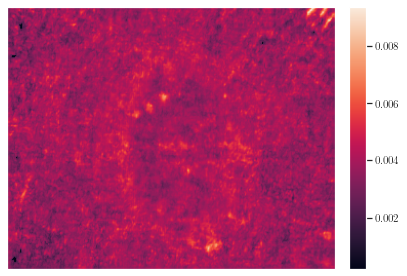

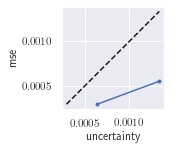

In [5]:
mc_iter = 5

losses = {}
psnrs = {}
ssims = {}

ale_maps = []
epi_maps = []
uncert_maps = []

uncerts = []

for label, run in zip(labels, runs):
    try:
        results = torch.load(f"{run}/results.pt", map_location=device)
    except:
        print(run)
        continue
    net_info = json.load(open(f"{run}/net_info.json"))
    if "img_name" in list(net_info.keys()):
        img_name = net_info["img_name"]
        imsize = net_info["imsize"]
    #img_name = "xray"
    #imsize = -1
    
    psnrs[label] = results["psnr_gt_sm"]
    #ssims[label] = results["ssim_gt_sm"]
    losses[label] = results["mse_corrupted"]
    
    if label != "DIP":
        net = get_trained_net(net_info, results["state_dict"], task)
        net_input = results["net_input"]

        imgs = get_imgs(img_name, task, imsize=imsize, factor=2)#, sigma=net_info["sigma"])
        for name, img in imgs.items():
            if isinstance(img, np.ndarray):
                _img = img[0] if img.shape[0] == 1 else np.moveaxis(img, 0, -1)
                _img = cv2.resize(_img, (net_input.shape[-1], net_input.shape[-2]))
                imgs[name] = _img[np.newaxis] if len(_img.shape) == 2 else np.moveaxis(_img, -1 ,0)

        img_corrupted_torch, downsampler, mask = get_task_specifics(imgs, task, net_info)
        img_corrupted_torch = img_corrupted_torch.to(device)

        if results["sgld_imgs"] is None:

            if downsampler is not None:
                downsampler = downsampler.to(device)
            img_list = get_mc_preds(net.to(device), net_input.to(device), mc_iter, post_processor=downsampler)
            ale, epi, uncert = uncert_regression_gal(img_list, reduction=None)

            out_torch_mean = torch.mean(torch.cat(img_list, dim=0)[:], dim=0, keepdim=True)

        else:
            sgld_imgs = results["sgld_imgs"]

            #if sgld_imgs[0].shape[0,0] == 2:
            #    ale, epi, uncert = uncert_regression_gal(sgld_imgs)
            #    out_torch_mean = torch.mean(torch.cat(sgld_imgs, dim=0)[:,:-1], dim=0)
            #else:
            sgld_imgs = torch.cat(sgld_imgs, dim=0)
            epi = uncert = torch.var(sgld_imgs[:,0], dim=0, keepdim=True).unsqueeze(1)
            ale = torch.zeros(epi.size())
            out_torch_mean = torch.mean(sgld_imgs[:,:], dim=0, keepdim=True)

        mse_err = F.mse_loss(out_torch_mean[:,:-1].to(device) * mask.to(device), img_corrupted_torch, reduction='none')
        mse_err = torch.mean(mse_err, dim=1, keepdim=True)

        uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(mse_err.to(device), uncert.to(device), n_bins=10, outlier=0.02)

        plot_uncert_map(uncert, with_colorbar=True, path=f"../uncert_map_{task}_{img_name}_{label}_cm.pdf")

        V.plot_uncert(err_in_bin.cpu().numpy(), avg_sigma_in_bin.cpu().numpy())
        plt.show()

In [8]:
#pruning_psnrs = {label: [] for label in labels}
pruning_range = np.hstack((np.arange(0, 0.95, 0.05), np.arange(0.91, 1.01, 0.01)))
mc_iter = 5

for label, run in zip(labels, runs):
    if label != "MFVI (ours)":
        continue
    results = torch.load(f"{run}/results.pt", map_location=device)
    net_info = json.load(open(f"{run}/net_info.json"))
    if "img_name" in list(net_info.keys()):
        img_name = net_info["img_name"]
        imsize = net_info["imsize"]
    #img_name = "xray"
    #imsize = -1
    
    imgs = get_imgs(img_name, task, imsize=imsize, factor=2)#, sigma=net_info["sigma"])
    for name, img in imgs.items():
        if isinstance(img, np.ndarray):
            _img = img[0] if img.shape[0] == 1 else np.moveaxis(img, 0, -1)
            _img = cv2.resize(_img, (net_input.shape[-1], net_input.shape[-2]))
            imgs[name] = _img[np.newaxis] if len(_img.shape) == 2 else np.moveaxis(_img, -1 ,0)
    img_corrupted_torch, downsampler, mask = get_task_specifics(imgs, task, net_info)
    img_corrupted_torch = img_corrupted_torch.to(device)
    
    pbar = tqdm(pruning_range)
    for amount in pbar:
        pbar.set_description(f"{label} | amount to be pruned: {np.round(amount * 100)}%")
        
        net = get_trained_net(net_info, results["state_dict"], task)
        net_input = results["net_input"]

        if isinstance(net, MeanFieldVI):
            prune_weights_ffg(net, mode='percentage', amount=amount)
        else:
            prune_weights(net, mode='percentage', amount=amount)

        if downsampler is not None:
            downsampler = downsampler.to(device)
        img_list = get_mc_preds(net.to(device), net_input.to(device), mc_iter, post_processor=downsampler)

        out_torch_mean = torch.mean(torch.cat(img_list, dim=0)[:], dim=0, keepdim=True)
        out_np_mean = out_torch_mean.detach().cpu().numpy()[0]
        
        img_compare = imgs["LR_np"] if task == "super_resolution" else imgs["gt"]
        
        psnr_gt = peak_signal_noise_ratio(img_compare, out_np_mean[:-1])
        psnr_corrupted = peak_signal_noise_ratio(img_corrupted_torch.cpu().numpy()[0], out_np_mean[:-1])

        pruning_psnrs[label].append([psnr_gt, psnr_corrupted])
    
    #plt.plot(pruning_range, np.array(pruning_psnrs[label]))
    #plt.show()

MFVI (ours) | amount to be pruned: 100.0%: 100%|██████████| 29/29 [01:21<00:00,  2.81s/it]


In [17]:
for key,val in pruning_psnrs.items():
    if key == "MFVI (ours)":
        pruning_psnrs[key] = val[-29:]

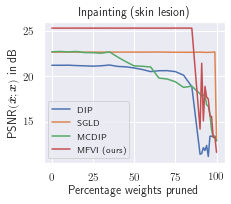

In [18]:
np_eval_plot([(pruning_range * 100).astype(np.int64) for _ in range(len(labels))], np.array(list(pruning_psnrs.values()))[:,:,0].tolist(), labels=pruning_psnrs.keys(), 
             xlabel=r'Percentage weights pruned', ylabel=r'PSNR$(\hat{\bm{x}};\bm{x})$ in dB', sigma=0, step=1, title=title, path=f'../psnrs_pruned_{task}_{img_name}.pdf')

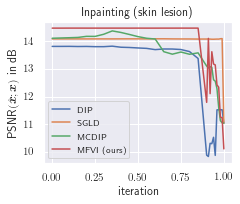

In [21]:
np_eval_plot([pruning_range for _ in range(len(labels))], np.array(list(pruning_psnrs.values()))[:,:,1].tolist(), labels=pruning_psnrs.keys(), 
             ylabel=r'PSNR$(\hat{\bm{x}};\bm{x})$ in dB', sigma=0, step=1, title=title)#, path=f'../psnrs_pruned_{task}_{img_name}_2_corrupted.pdf')

In [ ]:
xs = [range(len(list(psnrs.values())[i])) for i in range(len(list(psnrs.values())))]
np_eval_plot(xs, psnrs.values(), labels=psnrs.keys(), ylabel=r'PSNR$(\hat{\bm{x}};\bm{x})$ in dB', 
             xtlf='sci', sigma=0, title=title)#, path='psnrs.pdf')

In [ ]:
#np_eval_plot(xs, ssims.values(), labels=ssims.keys(), ylabel=r'SSIM$(\hat{\bm{x}};\bm{x})$', xtlf='sci', title=title)#, path='ssims.pdf')

In [ ]:
np_eval_plot(xs, losses.values(), labels=losses.keys(), ylabel=r'MSE$(\tilde{\bm{x}};\hat{\bm{x}})$', sigma=50, ytlf='sci', xtlf='sci', 
             ylim=[-0.001,0.026], title=title)#, path='mses.pdf')

In [ ]:
print(f"PSNR_gt_sm results for {task} ({img_name})")
for key, values in psnrs.items():
    print(f"{key}:\tEarly Stopping: {np.round(np.array(values).max(), 2)}\t|\tLast 100: {np.round(np.mean(np.array(values)[-100:]), 2)}")